<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
from datetime import datetime

from helpers_image import show
from helpers_config import load_config, save_config
from unet import UNet

Using TensorFlow backend.


In [2]:
config = load_config(path="../outputs/unet/config.json")
#dir_name = datetime.today().strftime("%Y%m%d_%H%M%S")
save_dir = config['dst_path'] + config['model_name'] + "/"

save_dir

'../outputs/unet/'

In [3]:
pipeline = UNet(patch_size=config['patch_size'],
                data_dir=config['data_dir'],
                initial_epoch=config['initial_epoch'],
                tr_losses=config['tr_losses'],
                val_losses=config['val_losses'])

In [4]:
X_tr, Y, X_te = pipeline.load_data(sample_tr_img=config['sample_tr_size'],
                                   sample_te_img=config['sample_te_size'],
                                   stride=config['stride'],
                                   rotations=config['rotations'])

loading data...
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
(40500, 40, 40, 3)
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 8100
expected number of patches = 20164
expected number of patches = 20164
expected number of patches = 20164
expected number of patches = 20164
expected number of patches = 20164
40500 40500


In [6]:
X_te.shape

(100820, 40, 40, 3)

In [5]:
i = 0
show([X_tr[i], Y[i]])

NameError: name 'X_tr' is not defined

In [8]:
pipeline.train_model(X_tr=X_tr,
                     Y=Y,
                     epochs=config['epochs'],
                     sample_size=config['sample_tr_size'],
                     batch_size=config['batch_size'],
                     verbose=config['verbose'],
                     validation_split=config['validation_split'],
                     shuffle=config['shuffle'],
                     load_checkpoint=config['load_checkpoint'],
                     checkpoint_path=save_dir,
                     save_best_only=config['save_best_only'])

loading weights from ../outputs/unet/weights.hdf5
loading model...


C:\Users\Greg\Programming\Python\ml2017\project02\src\unet.py:76: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merge6 = merge([drop4, up6], mode='concat', concat_axis=3)
C:\Users\Greg\Anaconda3\envs\py36\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Greg\Programming\Python\ml2017\project02\src\unet.py:82: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merge7 = merge([conv3, up7], mode='concat', concat_axis=3)
C:\Users\Greg\Programming\Python\ml2017\project02\src\unet.py:88: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from 

model loaded
weights loaded
training model...
Train on 4 samples, validate on 1 samples
Epoch 3/3
Epoch 00003: val_loss improved from inf to 0.69294, saving model to ../outputs/unet/weights.hdf5
4/4 [==============================] - 58s 15s/step - loss: 0.6936 - acc: 0.7890 - val_loss: 0.6929 - val_acc: 0.7959
model training done


In [9]:
pipeline.initial_epoch

3

In [10]:
pipeline.val_losses

[0.6933249831199646, 0.6932715773582458, 0.6929442286491394]

In [10]:
predictions = pipeline.predict(X_te=X_te, sample_size=config['sample_te_size'])

ValueError: Error when checking : expected input_1 to have shape (None, 400, 400, 3) but got array with shape (5, 608, 608, 3)

In [11]:
Y_tr = pipeline.predict(X_tr, sample_size=5)

5/5 [==============================] - 20s 4s/step


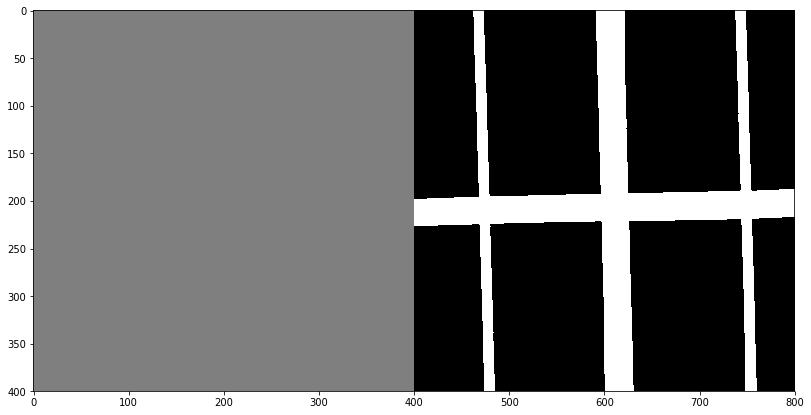

In [19]:
i = 0
show([Y_tr[i], Y[i]])

In [29]:
save_output(pipeline.model,
                     predictions=Y_tr,
                     path=save_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../outputs/unet/'